In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.sdes as sdes
import model.generate as generate
import model.table_dnn as table_dnn
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.linalg
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

branched_model_path = os.path.join(models_base_path, "letters_continuous_allletters/2/epoch_300_ckpt.pth")
label_guided_model_path = os.path.join(models_base_path, "letters_continuous_allletters_labelguided/1/epoch_100_ckpt.pth")

In [5]:
# Define the branches
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
class_to_letter = dict(enumerate(letters))
letter_to_class = {v : k for k, v in class_to_letter.items()}

classes = [letter_to_class[l] for l in letters]
branch_defs = [(('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'), 0.5235235235235235, 1), (('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.5165165165165165, 0.5235235235235235), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.5115115115115115, 0.5165165165165165), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.4944944944944945, 0.5115115115115115), (('I', 'J'), 0.4794794794794795, 0.4944944944944945), (('B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z'), 0.4724724724724725, 0.4944944944944945), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'M', 'N', 'O', 'Q', 'R', 'S', 'U', 'X', 'Z'), 0.45645645645645644, 0.4724724724724725), (('F', 'P', 'T', 'V', 'Y'), 0.4364364364364364, 0.4724724724724725), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'U', 'X', 'Z'), 0.4174174174174174, 0.45645645645645644), (('B', 'C', 'D', 'E', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.4134134134134134, 0.4174174174174174), (('B', 'D', 'G', 'H', 'K', 'N', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.4094094094094094, 0.4134134134134134), (('F', 'T', 'V', 'Y'), 0.4024024024024024, 0.4364364364364364), (('B', 'D', 'G', 'H', 'K', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3863863863863864, 0.4094094094094094), (('B', 'G', 'H', 'K', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3813813813813814, 0.3863863863863864), (('B', 'G', 'H', 'O', 'Q', 'R', 'S', 'X', 'Z'), 0.3733733733733734, 0.3813813813813814), (('F', 'T', 'Y'), 0.36036036036036034, 0.4024024024024024), (('C', 'E'), 0.3563563563563564, 0.4134134134134134), (('T', 'Y'), 0.3533533533533533, 0.36036036036036034), (('B', 'R', 'S', 'X', 'Z'), 0.35135135135135137, 0.3733733733733734), (('G', 'H', 'O', 'Q'), 0.34134134134134136, 0.3733733733733734), (('B', 'S', 'X', 'Z'), 0.32232232232232233, 0.35135135135135137), (('B', 'S', 'X'), 0.27627627627627627, 0.32232232232232233), (('G', 'H', 'O'), 0.26426426426426425, 0.34134134134134136), (('G', 'O'), 0.25725725725725723, 0.26426426426426425), (('S', 'X'), 0.15615615615615616, 0.27627627627627627), (('W',), 0, 0.5235235235235235), (('A',), 0, 0.5165165165165165), (('L',), 0, 0.5115115115115115), (('J',), 0, 0.4794794794794795), (('I',), 0, 0.4794794794794795), (('M',), 0, 0.45645645645645644), (('P',), 0, 0.4364364364364364), (('U',), 0, 0.4174174174174174), (('N',), 0, 0.4094094094094094), (('V',), 0, 0.4024024024024024), (('D',), 0, 0.3863863863863864), (('K',), 0, 0.3813813813813814), (('F',), 0, 0.36036036036036034), (('E',), 0, 0.3563563563563564), (('C',), 0, 0.3563563563563564), (('Y',), 0, 0.3533533533533533), (('T',), 0, 0.3533533533533533), (('R',), 0, 0.35135135135135137), (('Q',), 0, 0.34134134134134136), (('Z',), 0, 0.32232232232232233), (('B',), 0, 0.27627627627627627), (('H',), 0, 0.26426426426426425), (('G',), 0, 0.25725725725725723), (('O',), 0, 0.25725725725725723), (('S',), 0, 0.15615615615615616), (('X',), 0, 0.15615615615615616)]

branch_defs = [
    (tuple(map(lambda l: letter_to_class[l], trip[0])), trip[1], trip[2])
    for trip in branch_defs
]

input_shape = (16,)

In [6]:
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

In [7]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/letters_sample_quality"

os.makedirs(out_path, exist_ok=True)

### Create data loader

In [8]:
class LetterDataset(torch.utils.data.Dataset):
    def __init__(self):
        data_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/letter_recognition/letter-recognition.data"
        
        data = []
        targets = []
        with open(data_path, "r") as f:
            for line in f:
                tokens = line.strip().split(",")
                targets.append(tokens[0])
                data.append(np.array(list(map(int, tokens[1:]))))
        self.data = np.stack(data)
        self.targets = np.array([letter_to_class[l] for l in targets])
        
        # Center/normalize the data
        self.data = (self.data - np.mean(self.data, axis=0, keepdims=True)) / \
            np.std(self.data, axis=0, keepdims=True)
        
    def __getitem__(self, index):
        return torch.tensor(self.data[index]).float(), self.targets[index]
        
    def __len__(self):
        return len(self.targets)
    
dataset = LetterDataset()

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [9]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

def class_to_class_index_tensor(c):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

### Import models

In [10]:
branched_model = model_util.load_model(
    table_dnn.MultitaskTabularNet, branched_model_path
).to(DEVICE)

label_guided_model = model_util.load_model(
    table_dnn.LabelGuidedTabularNet, label_guided_model_path
).to(DEVICE)

### Sample letters

In [11]:
# Sample digits of each class from branched model
branched_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        branched_model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit, num_samples=1000
    ).cpu().numpy()
    branched_samples[class_to_sample] = samples

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Sampling class: 10
Sampling class: 11
Sampling class: 12
Sampling class: 13
Sampling class: 14
Sampling class: 15
Sampling class: 16
Sampling class: 17
Sampling class: 18
Sampling class: 19
Sampling class: 20
Sampling class: 21
Sampling class: 22
Sampling class: 23
Sampling class: 24
Sampling class: 25


In [12]:
# Sample digits of each class from label-guided model
label_guided_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_label_guided_samples(
        label_guided_model, sde, class_to_sample, class_to_class_index_tensor,
        sampler="pc", t_limit=t_limit, num_samples=1000
    ).cpu().numpy()
    label_guided_samples[class_to_sample] = samples

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Sampling class: 10
Sampling class: 11
Sampling class: 12
Sampling class: 13
Sampling class: 14
Sampling class: 15
Sampling class: 16
Sampling class: 17
Sampling class: 18
Sampling class: 19
Sampling class: 20
Sampling class: 21
Sampling class: 22
Sampling class: 23
Sampling class: 24
Sampling class: 25


In [13]:
# Sample digits from the original dataset
true_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    inds = np.where(dataset.targets == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=700, replace=False)
    samples = dataset.data[sample_inds]
    true_samples[class_to_sample] = samples

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Sampling class: 10
Sampling class: 11
Sampling class: 12
Sampling class: 13
Sampling class: 14
Sampling class: 15
Sampling class: 16
Sampling class: 17
Sampling class: 18
Sampling class: 19
Sampling class: 20
Sampling class: 21
Sampling class: 22
Sampling class: 23
Sampling class: 24
Sampling class: 25


### Show true/predicted distributions

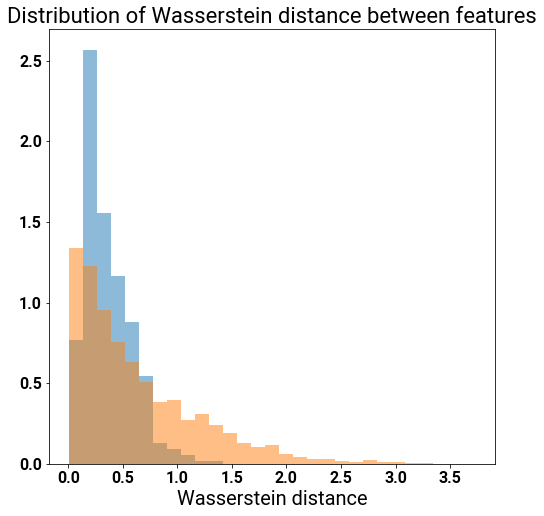

In [14]:
# Plot the overall distribution of Wasserstein distance between feature distributions,
# both between true/predicted distributions, and between true predictions
num_features = input_shape[0]
true_pred_dists = {}
true_true_dists = {}
for i in range(num_features):
    for class_to_sample in classes:
        true = true_samples[class_to_sample][:, i]
        generated = branched_samples[class_to_sample][:, i]
        true_pred_dists[(class_to_sample, i)] = scipy.stats.wasserstein_distance(true, generated)
    
    for c_i1 in range(len(classes)):
        for c_i2 in range(c_i1):
            c1, c2 = classes[c_i1], classes[c_i2]
            true_1, true_2 = true_samples[c1][:, i], true_samples[c2][:, i]
            true_true_dists[(c1, c2, i)] = scipy.stats.wasserstein_distance(true_1, true_2)
        
num_bins = 30
fig, ax = plt.subplots(figsize=(8, 8))
true_pred_vals, true_true_vals = np.array(list(true_pred_dists.values())), np.array(list(true_true_dists.values()))
all_vals = np.concatenate([true_pred_vals, true_true_vals])
bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
ax.hist(true_pred_vals, bins=bins, label="True vs generated features", alpha=0.5, density=True)
ax.hist(true_true_vals, bins=bins, label="True vs true features", alpha=0.5, density=True)
ax.set_title("Distribution of Wasserstein distance between features")
ax.set_xlabel("Wasserstein distance")
plt.show()
fig.savefig(
    os.path.join(out_path, "letters_feature_distance_all.svg"),
    format="svg"
)

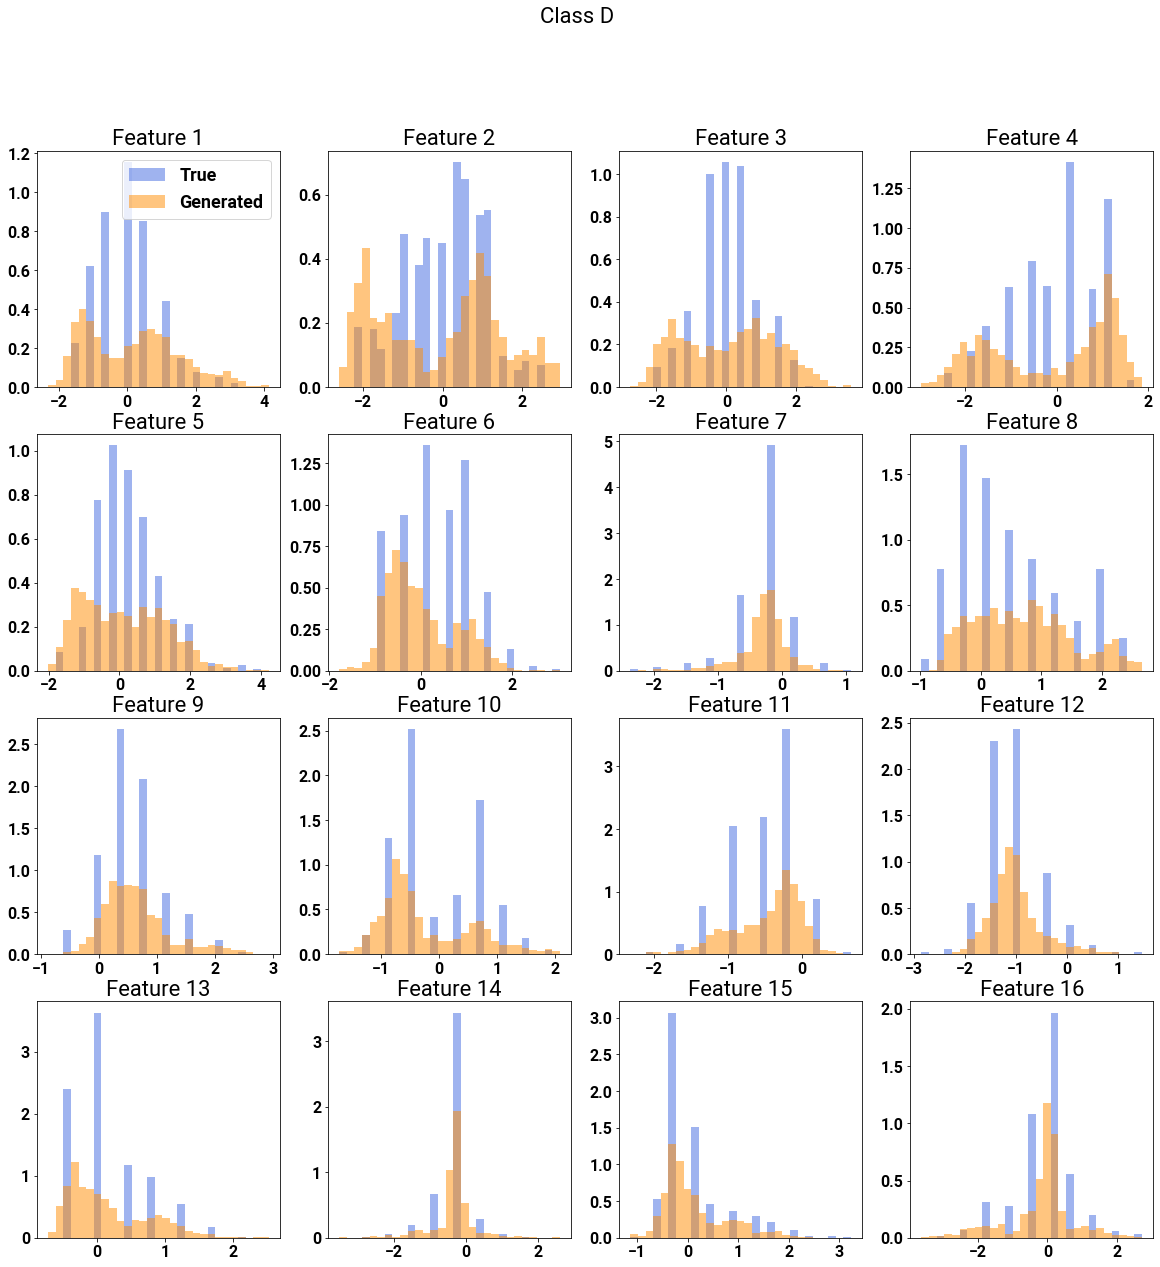

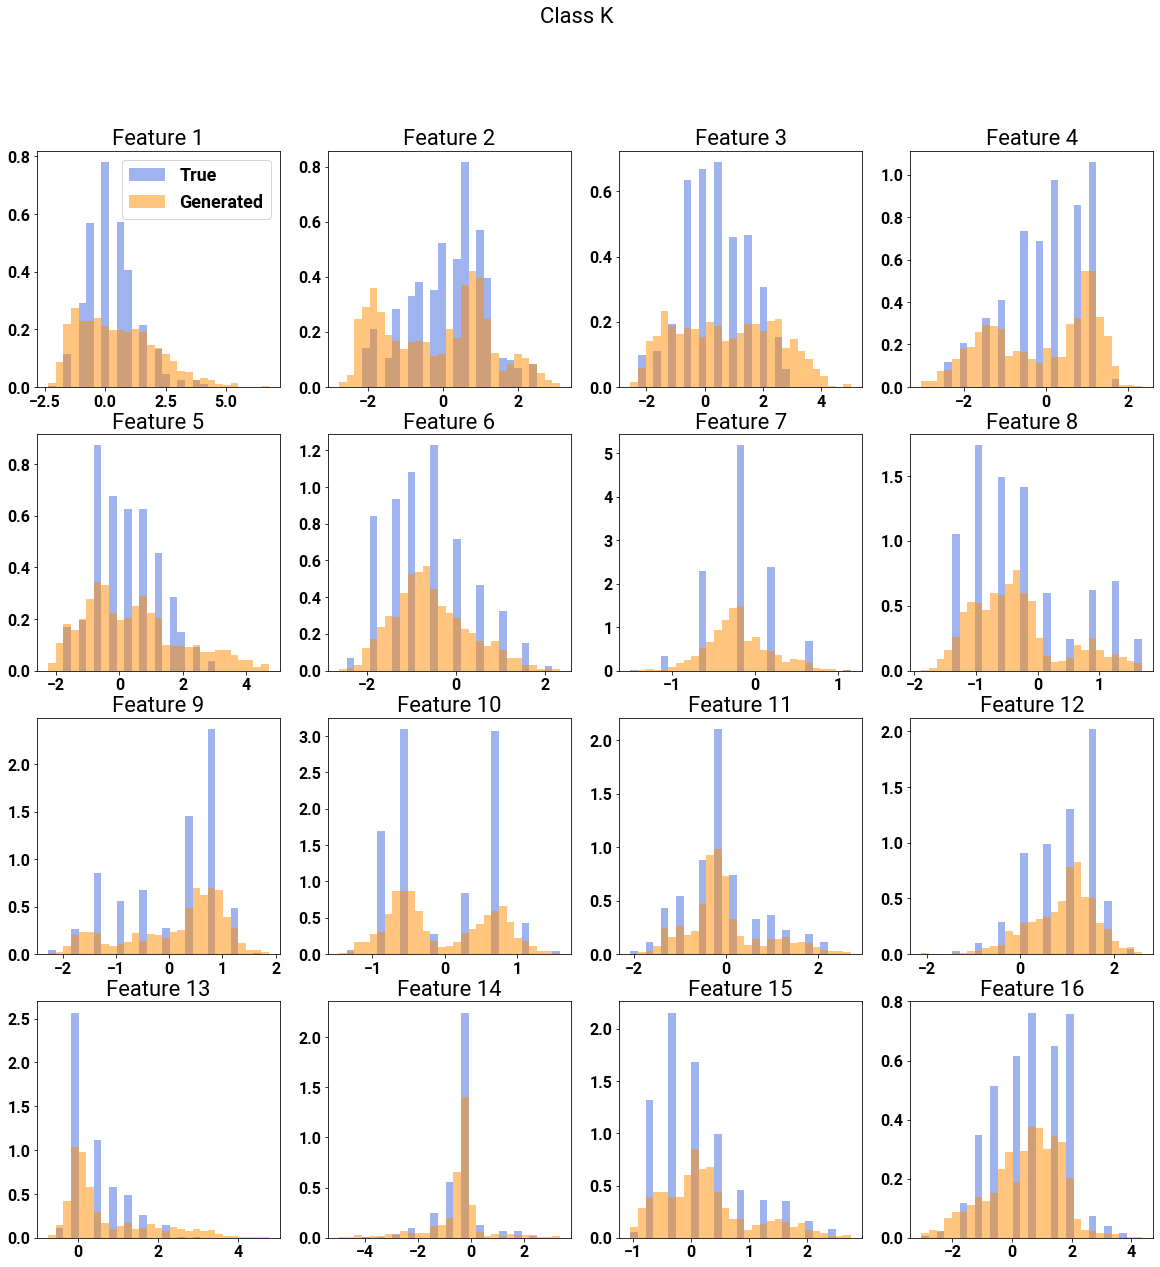

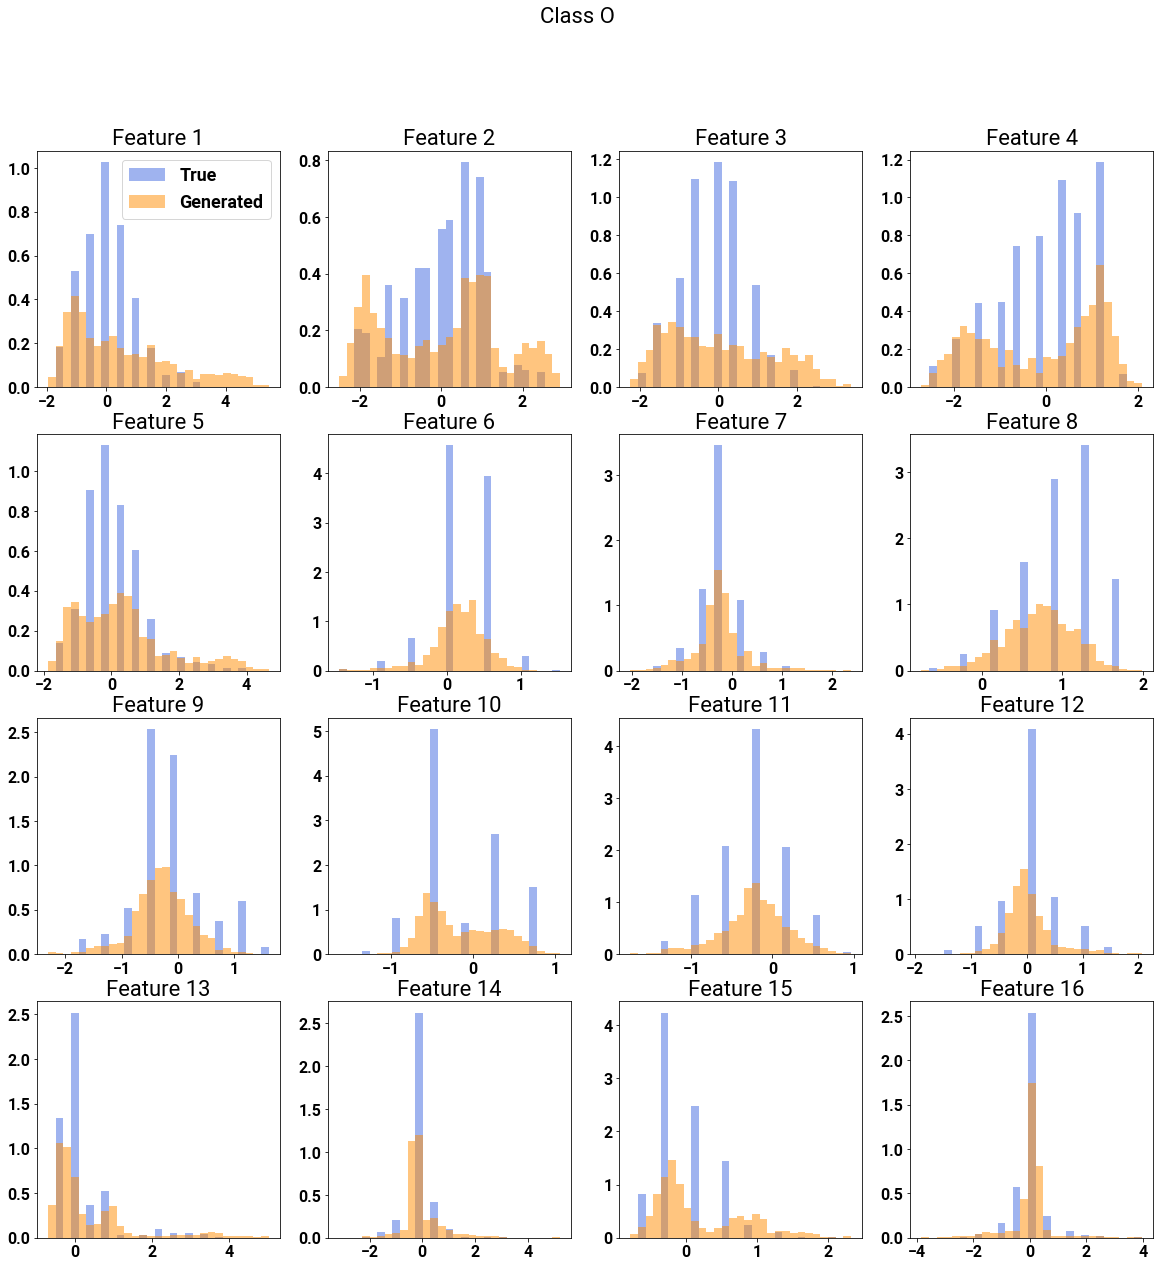

In [15]:
# Plot some example distributions of all features for certain classes
mean_true_pred_dists = {c : [] for c in classes}
for (c, _), dist in true_pred_dists.items():
    mean_true_pred_dists[c].append(dist)
for c, vals in mean_true_pred_dists.items():
    mean_true_pred_dists[c] = np.mean(vals)
    
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 30
    
for class_to_show in sorted(mean_true_pred_dists.keys(), key=lambda k: mean_true_pred_dists[k])[:3]:
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i in range(num_features):
        r, c = i // num_cols, i % num_cols
        true = np.ravel(true_samples[class_to_show][:, i])
        generated = np.ravel(branched_samples[class_to_show][:, i])
        all_vals = np.concatenate([true, generated])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(true, bins=bins, color="royalblue", label="True", density=True, alpha=0.5)
        ax[r][c].hist(generated, bins=bins, color="darkorange", label="Generated", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % (i + 1))
    ax[0][0].legend()
    fig.suptitle("Class %s" % class_to_letter[class_to_show])
    plt.show()
    fig.savefig(
        os.path.join(out_path, "letters_feature_distance_%s.svg" % class_to_letter[class_to_show]),
        format="svg"
    )

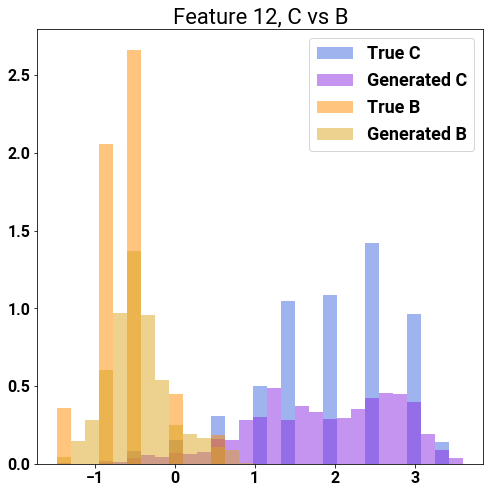

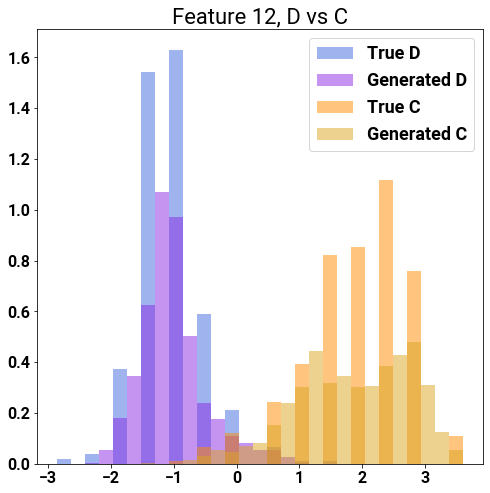

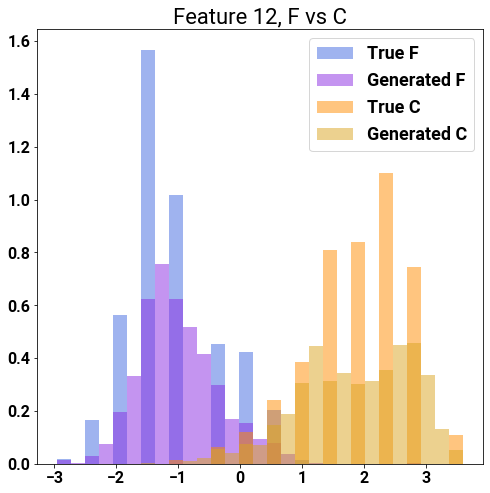

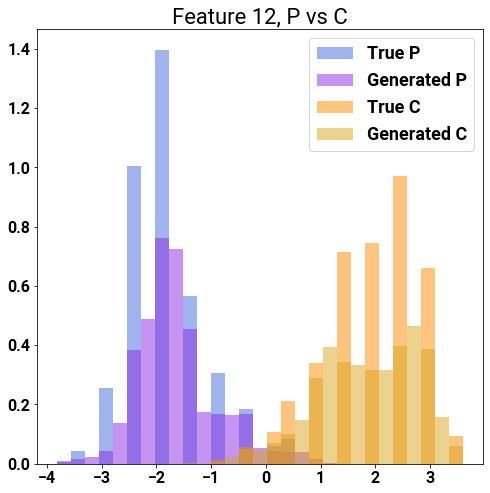

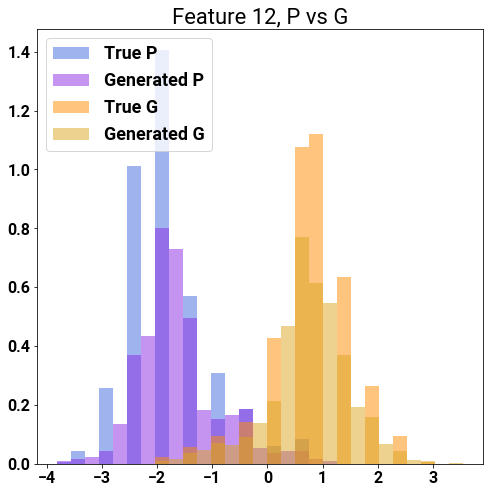

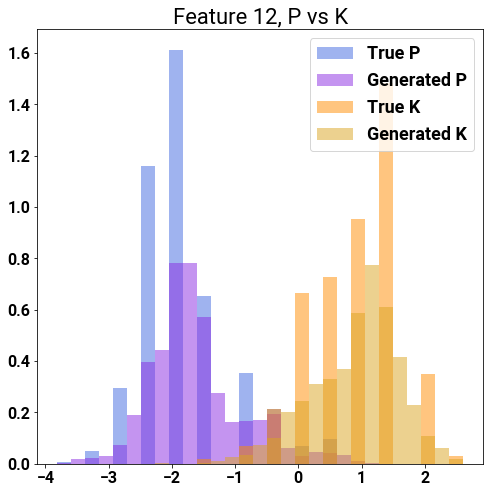

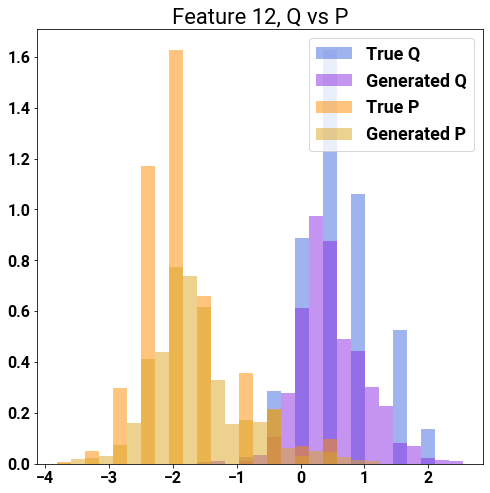

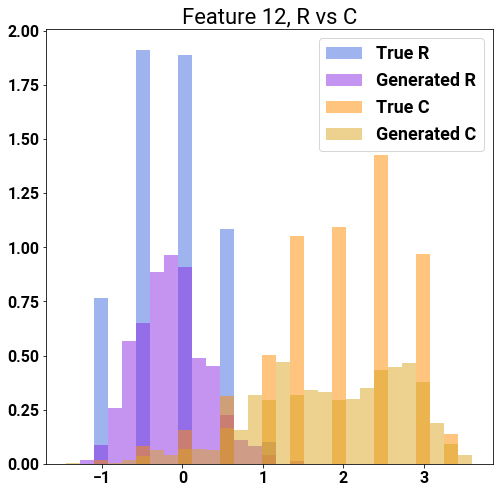

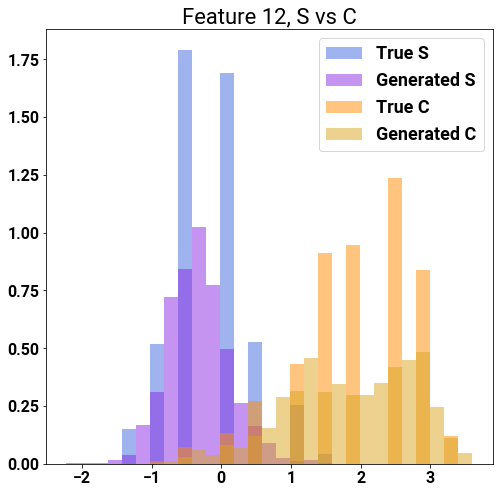

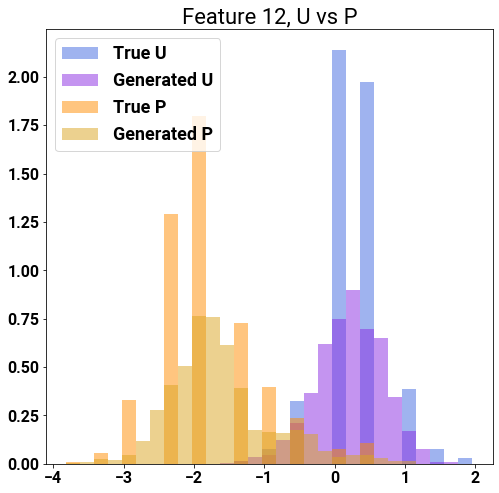

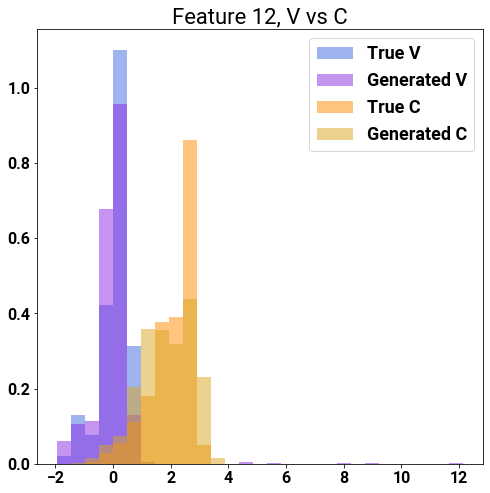

In [16]:
# Plot some example distributions of specific features for multiple classes
num_bins = 30
for (c1, c2, i), t_t_val in true_true_dists.items():
    p_t_val_1, p_t_val_2 = true_pred_dists[(c1, i)], true_pred_dists[(c2, i)]
    if t_t_val > 2 and p_t_val_1 < 0.2 and p_t_val_2 < 0.2:
        fig, ax = plt.subplots(figsize=(8, 8))
        true_1 = np.ravel(true_samples[c1][:, i])
        generated_1 = np.ravel(branched_samples[c1][:, i])
        true_2 = np.ravel(true_samples[c2][:, i])
        generated_2 = np.ravel(branched_samples[c2][:, i])
        all_vals = np.concatenate([true_1, generated_1, true_2, generated_2])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax.hist(
            true_1, bins=bins, color="royalblue", label=("True %s" % class_to_letter[c1]), density=True, alpha=0.5
        )
        ax.hist(
            generated_1, bins=bins, color="blueviolet", label=("Generated %s" % class_to_letter[c1]), density=True, alpha=0.5
        )
        ax.hist(
            true_2, bins=bins, color="darkorange", label=("True %s" % class_to_letter[c2]), density=True, alpha=0.5
        )
        ax.hist(
            generated_2, bins=bins, color="goldenrod", label=("Generated %s" % class_to_letter[c2]), density=True, alpha=0.5
        )
        ax.set_title("Feature %d, %s vs %s" % (i + 1, class_to_letter[c1], class_to_letter[c2]))
        ax.legend()
        plt.show()
        fig.savefig(
            os.path.join(out_path, "letters_feature_distance_%s_%s.svg" % (class_to_letter[c1], class_to_letter[c2])),
            format="svg"
        )

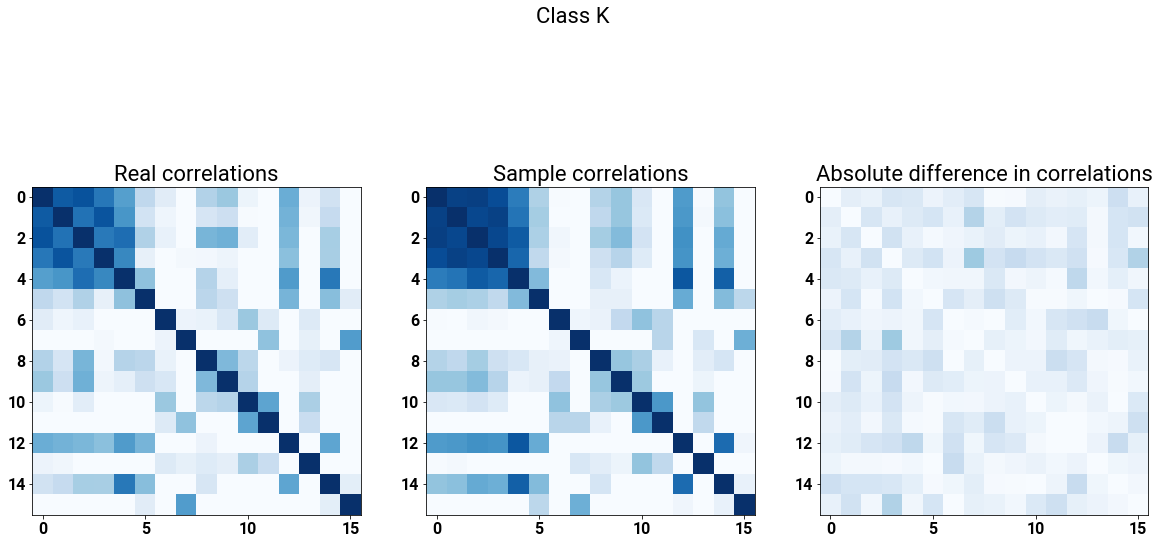

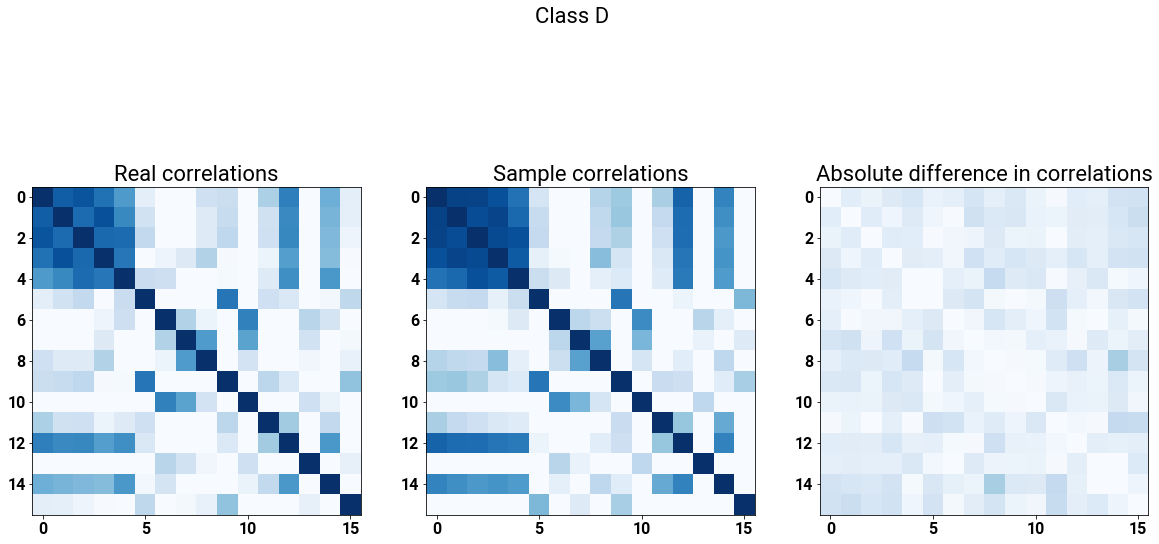

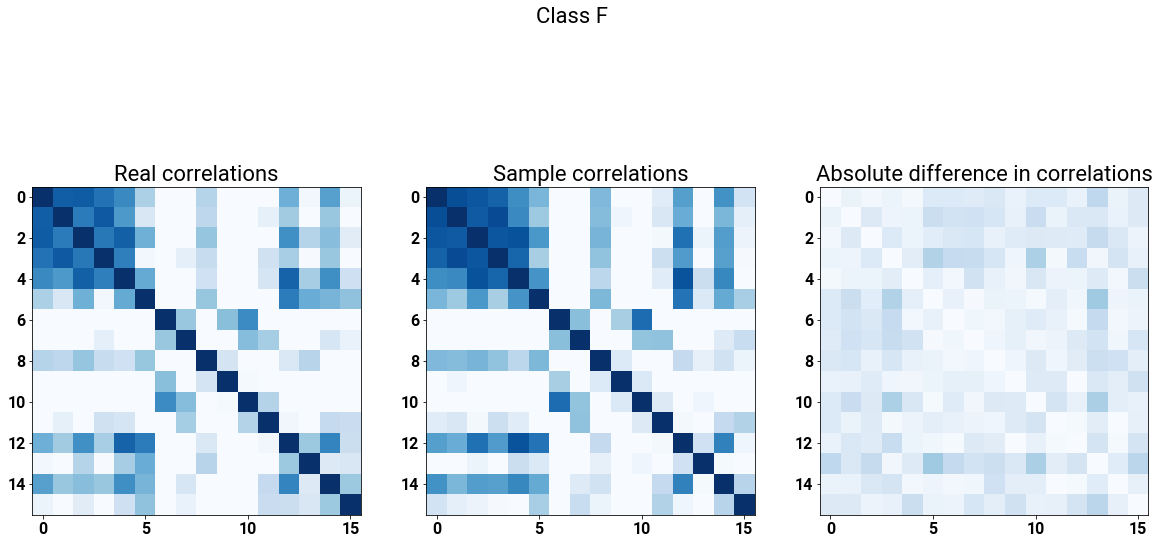

In [18]:
# Show true and predicted correlations between features
true_corrs = np.empty((len(classes), num_features, num_features))
generated_corrs = np.empty((len(classes), num_features, num_features))
for c_i, c in enumerate(classes):
    true = true_samples[c]
    generated = branched_samples[c]
    for i in range(num_features):
        true_corrs[c_i, i, i] = 1
        generated_corrs[c_i, i, i] = 1
        for j in range(i):
            true_corrs[c_i, i, j] = scipy.stats.pearsonr(true[:, i], true[:, j])[0]
            true_corrs[c_i, j, i] = true_corrs[c_i, i, j]
            generated_corrs[c_i, i, j] = scipy.stats.pearsonr(generated[:, i], generated[:, j])[0]
            generated_corrs[c_i, j, i] = generated_corrs[c_i, i, j]
            
for c_i in np.argsort(np.mean(np.abs(true_corrs - generated_corrs), axis=(1, 2)))[:3]:
    fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
    ax[0].imshow(true_corrs[c_i], cmap="Blues", vmin=0, vmax=1)
    ax[0].set_title("Real correlations")
    ax[1].imshow(generated_corrs[c_i], cmap="Blues", vmin=0, vmax=1)
    ax[1].set_title("Sample correlations")
    ax[2].imshow(np.abs(true_corrs[c_i] - generated_corrs[c_i]), cmap="Blues", vmin=0, vmax=1)
    ax[2].set_title("Absolute difference in correlations")
    fig.suptitle("Class %s" % class_to_letter[classes[c_i]])
    plt.show()
    fig.savefig(
        os.path.join(out_path, "letters_feature_corr_%s.svg" % class_to_letter[classes[c_i]]),
        format="svg"
    )

### Compute FID

In [19]:
def compute_fid(samples_1, samples_2):
    """
    Computes the Frechet inception distance between two samples of
    objects. Although the two arrays can have any shape (number of
    dimensions must be at least 2), they must be the same shape and
    distance will be computed by flattening anything after the batch
    dimension.
    Arguments:
        `samples_1`: a B x ... array of B samples
        `samples_2`: a B' x ... array of B' samples, in the same shape
            as `samples_1`
    Returns a scalar FID score.
    """
    assert samples_1.shape[1:] == samples_2.shape[1:]
    assert len(samples_1.shape) >= 2
    
    samples_1 = np.reshape(samples_1, (samples_1.shape[0], -1))
    samples_2 = np.reshape(samples_2, (samples_2.shape[0], -1))
    # Shape: B x D
    
    mean_1, cov_1 = np.mean(samples_1, axis=0), np.cov(np.transpose(samples_1))
    mean_2, cov_2 = np.mean(samples_2, axis=0), np.cov(np.transpose(samples_2))
    # Mean shape: D; Covariance matrix shape: D x D
    
    mean_square_norm = np.sum(np.square(mean_1 - mean_2))
    
    # Compute covariance term; because covariance matrices are symmetric,
    # the order of multiplication here doesn't matter
    cov_mean = scipy.linalg.sqrtm(np.matmul(cov_1, cov_2))
    if np.iscomplexobj(cov_mean):
        # Disscard imaginary part if needed
        cov_mean = np.real(cov_mean)
    cov_term = np.trace(cov_1 + cov_2 - (2 * cov_mean))
    
    return mean_square_norm + cov_term

In [20]:
# Compute FID scores
fid_scores = {}
for class_to_sample in classes:
    print("FID of %d" % class_to_sample)
    branched = branched_samples[class_to_sample]
    label_guided = label_guided_samples[class_to_sample]
    true = true_samples[class_to_sample]
    branched_fid = compute_fid(branched, true)
    label_guided_fid = compute_fid(label_guided, true)
    fid_scores[class_to_sample] = (branched_fid, label_guided_fid)
    print("Branched FID: %.4f" % branched_fid)
    print("Label-guided FID: %.4f" % label_guided_fid)

FID of 0
Branched FID: 6.5669
Label-guided FID: 2.3857
FID of 1
Branched FID: 3.0796
Label-guided FID: 1.8999
FID of 2
Branched FID: 2.8428
Label-guided FID: 2.4121
FID of 3
Branched FID: 1.5624
Label-guided FID: 2.9468
FID of 4
Branched FID: 3.2197
Label-guided FID: 2.7518
FID of 5
Branched FID: 2.3645
Label-guided FID: 5.4444
FID of 6
Branched FID: 4.0659
Label-guided FID: 2.9996
FID of 7
Branched FID: 3.7111
Label-guided FID: 3.4262
FID of 8
Branched FID: 9.3694
Label-guided FID: 8.6714
FID of 9
Branched FID: 5.9110
Label-guided FID: 9.5149
FID of 10
Branched FID: 2.5310
Label-guided FID: 1.4635
FID of 11
Branched FID: 9.3129
Label-guided FID: 5.6681
FID of 12
Branched FID: 4.1369
Label-guided FID: 21.3316
FID of 13
Branched FID: 3.9477
Label-guided FID: 8.9385
FID of 14
Branched FID: 2.7810
Label-guided FID: 2.7939
FID of 15
Branched FID: 2.3683
Label-guided FID: 4.2179
FID of 16
Branched FID: 2.4839
Label-guided FID: 5.3739
FID of 17
Branched FID: 3.7538
Label-guided FID: 5.4927
F

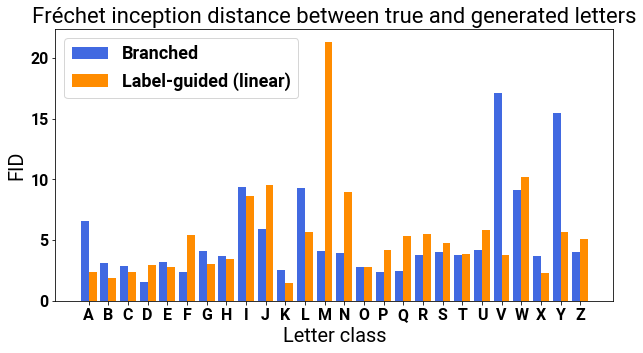

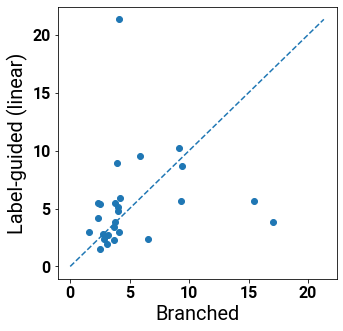

In [21]:
branched_vals, linear_vals = [fid_scores[c][0] for c in classes], [fid_scores[c][1] for c in classes]
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.4
x = np.arange(len(fid_scores))
ax.bar(
    x, branched_vals, bar_width, label="Branched", color="royalblue"
)
ax.bar(
    x + bar_width, linear_vals, bar_width, label="Label-guided (linear)", color="darkorange"
)
ax.set_xticks(x + (bar_width / 2), labels=[class_to_letter[c] for c in classes])
ax.set_xlabel("Letter class")
ax.set_ylabel("FID")
ax.set_title("Fréchet inception distance between true and generated letters")
ax.legend()
plt.show()
fig.savefig(
    os.path.join(out_path, "letters_fid.svg"),
    format="svg"
)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(branched_vals, linear_vals)
ax.set_xlabel("Branched")
ax.set_ylabel("Label-guided (linear)")
max_val = np.max(branched_vals + linear_vals)
ax.plot((0, max_val), (0, max_val), "--")
plt.show()